In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import seaborn as sns
from scipy import interpolate
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from statsmodels.formula.api import ols

plt.style.use('seaborn-colorblind')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


In [3]:
# extract 10 largest departments
departments = earnings[earnings['year'] == 2017].groupby('dept_clean')['name'].agg(np.size).nlargest(10)
dept_list = departments.index
departments = earnings[(earnings['dept_clean'].isin(dept_list)) & (earnings['year'] == 2017)] \
                    .rename(index=str, columns={'dept_clean': 'Department'})  # for plot legend

In [4]:
# extract 10 most common job titles
titles = earnings[earnings['year'] == 2017].groupby('title_clean')['name'].agg(np.size).nlargest(10)
titles_list = titles.index
titles = earnings[(earnings['title_clean'].isin(titles_list)) & (earnings['year'] == 2017)] \
                .rename(index=str, columns={'title_clean': 'Job Title'})  # for plot legend

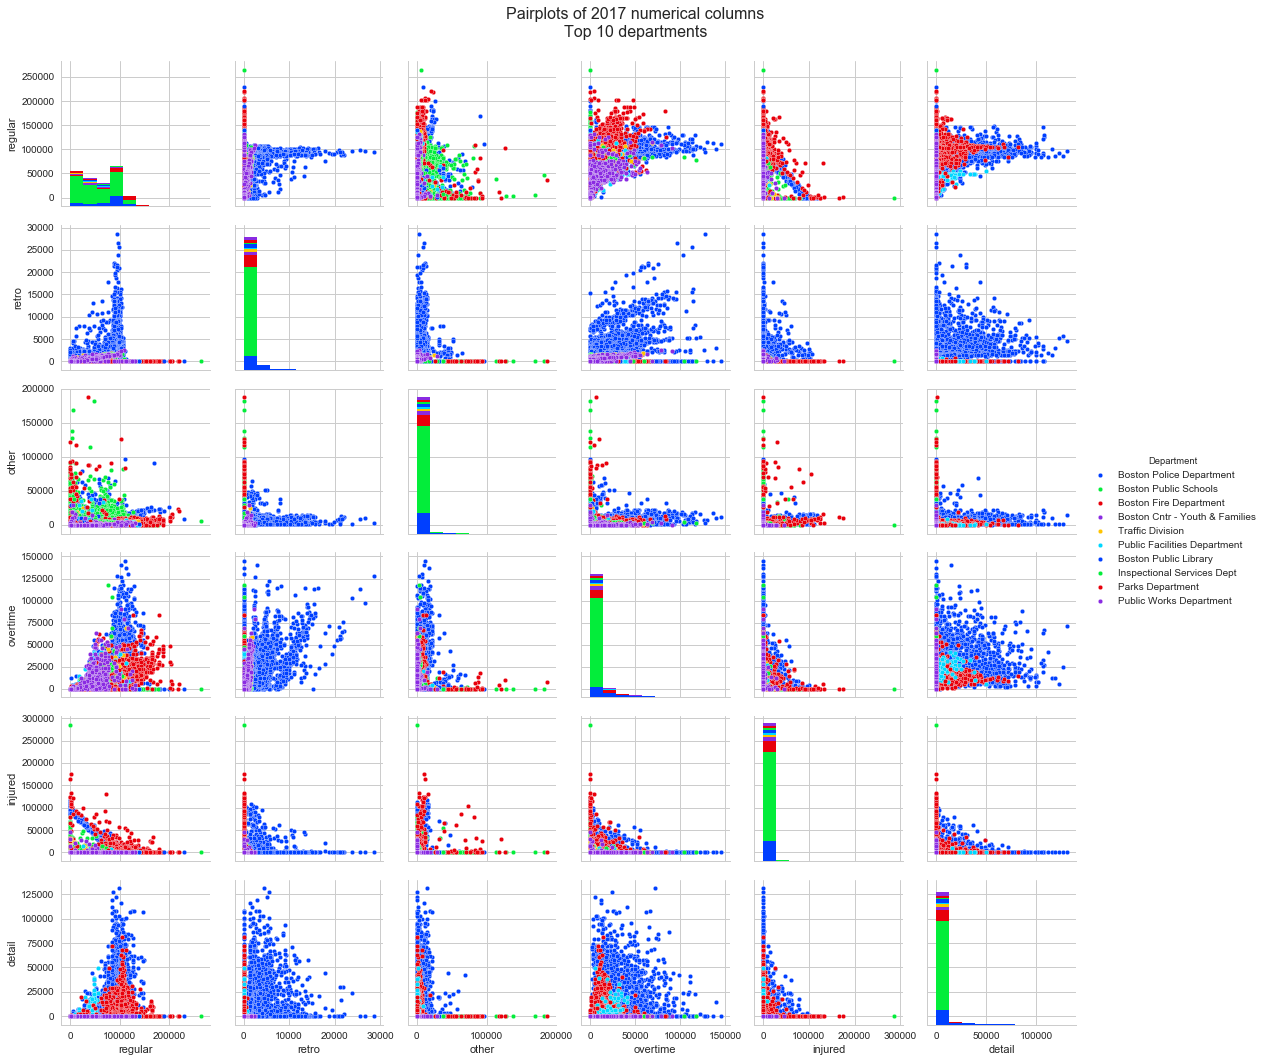

In [5]:
usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail']
g = sns.pairplot(departments, hue='Department', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 departments', fontsize=16)
plt.show()

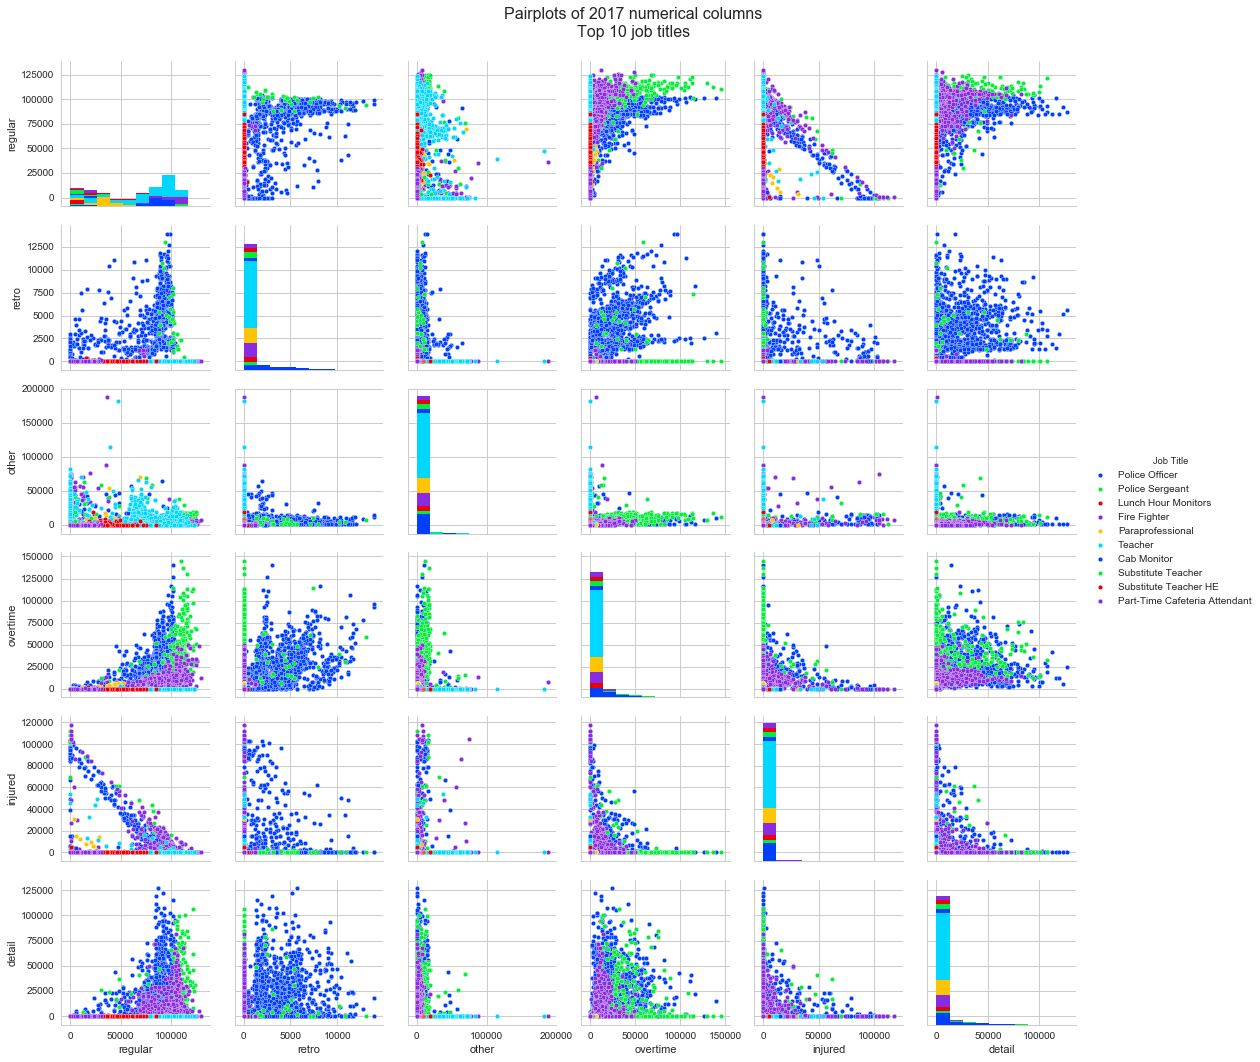

In [6]:
g = sns.pairplot(titles, hue='Job Title', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 job titles', fontsize=16)
plt.show()

The paired scatter plots above show the relationship between all of the numerical columns in the dataframe with exception of "Quinn" which is an education incentive specific to the police department, and "Total", which is the sum of the numerical columns. 

A few general observations follow:

- The charts are dominated by the highest paid employees: Police and fire fighters. 
- "Retro" payments are almost exclusive to the police department.
- "Overtime" is primarily for middle income employees. Salaried employees don't usually get overtime pay and lower income employees get overtime pay proportional to their income.
- "Injured" pay is mostly for police and fire fighters, and it appears to replace "regular" pay.
- "Detail" and "overtime" scatter plots have similar shapes and may possibly be alternative categories for similar compensation.

2017 number of employees: 393


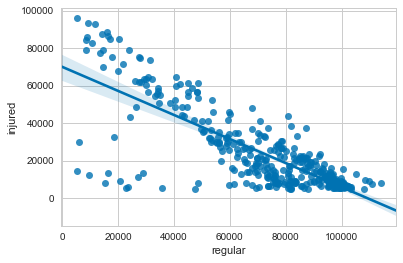

In [7]:
injured = titles[(titles.injured > 5000) & (titles.regular > 5000)] # remove "minor" injuries and very low income
print('2017 number of employees:', injured.shape[0])
sns.regplot(x='regular', y='injured', data=injured)
plt.show()

In [8]:
m = ols('regular ~ injured',injured).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     678.4
Date:                Tue, 27 Mar 2018   Prob (F-statistic):           1.91e-87
Time:                        14:30:25   Log-Likelihood:                -4350.8
No. Observations:                 393   AIC:                             8706.
Df Residuals:                     391   BIC:                             8714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    9.62e+04   1179.403     81.566      0.0

In [9]:
# all years, police officers & fire fighters
pol_ff = earnings[earnings['title_clean'].isin(['Police Officer', 'Fire Fighter'])]
print('Number of observations:', pol_ff.shape[0])

Number of observations: 18922


In [11]:
y = pol_ff['title_clean'].values
X = pol_ff[usecols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(random_state=42)
clf.fit(X_train, y_train)
print(metrics.accuracy_score(clf.predict(X_test), y_test))

0.6026420079260237


In [14]:
Cs = [10] #[0.001, 0.1, 1, 10, 100]
gamma = [0.001] #[0.001, 1/len(usecols), 1, 10, 100]
param_grid = {'C': Cs, 'gamma': gamma}
gs = GridSearchCV(clf, param_grid, cv=10)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

KeyboardInterrupt: 

In [15]:
clf = svm.SVC(C=10, gamma=0.001, random_state=42)
clf.fit(X_train, y_train)
print(metrics.accuracy_score(clf.predict(X_test), y_test))

0.6047556142668428


In [16]:
growth = pd.pivot_table(earnings, columns='year', index=['name', 'title_clean', 'dept_clean'], values='total')
print('Unique employees, 2011-2017:', growth.shape[0])
growth = growth.dropna()
growth['cagr'] = (growth.iloc[:,-1] / growth.iloc[:,-5]) ** (1/(len(growth.columns)-1)) - 1
growth = growth[growth['cagr'] > 0].reset_index() # filter retirees etc.
print('Continuously employed, 2011-2017', growth.shape[0])
growth = growth.groupby('title_clean')['name','cagr'].agg({'name':np.size, 'cagr':np.mean})
growth = growth[growth['name'] > 50]
growth

Unique employees, 2011-2017: 44043
Continuously employed, 2011-2017 7820


,name,cagr
title_clean,,
Cab Monitor,67,0.046088
Fire Fighter,737,0.034463
Fire Lieutenant,118,0.029729
Librarian,56,0.026340
Lunch Hour Monitors,144,0.022910
Nurse,64,0.018437
Paraprofessional,412,0.024929
Parking Meter Supervisor,83,0.036573
Part-Time Cafeteria Attendant,99,0.043469


In [ ]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['regular', 'total', 'name']]\
                        .agg({'regular': np.sum, 'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average total earnings per capita
total_payroll['rpc'] = total_payroll['regular'] / total_payroll['name'] # average regular earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
total_payroll['awi'] = pd.Series([42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15]) # AWI, years 2011-2016

"""
City of Boston population estimates
https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045216
2017 data is extrapolated from 2011-2016 data
"""

year_actual, pop_actual = np.array([2011, 2012, 2013, 2014, 2015, 2016]), np.array([630195, 641911, 651090, 659180, 665984, 673184])
f = interpolate.interp1d(year_actual, pop_actual, fill_value='extrapolate')
population = np.append(pop_actual, f(2017))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

x = total_payroll['year']

# Total payroll by year
ax1.bar(x, total_payroll['total']/1000000)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure (millions $)')
ax1.set_title('Total payroll by year')

# City population
ax2.bar(x, population/1000)
ax2.set_xlabel('year')
ax2.set_ylabel('Number of residents (thousands)')
ax2.set_title('City population (2017 estimated)')

# Employees per year
ax3.bar(x, total_payroll['name'])
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

# Average earnings per employee
ax4.bar(x, total_payroll['epc'])
ax4.plot(x, total_payroll['rpc'], alpha=1, color='r', linewidth=4)
ax4.plot(x, total_payroll['awi'], color='y', linewidth=4)
ax4.set_xlabel('year')
ax4.set_ylabel('average earnings ($)')
ax4.set_title('Average earnings per employee')
ax4.legend(['regular earnings', 'SSA average wage index', 'total earnings'])
ax4.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

The plots above show that the rate of payroll growth is slowing in the past few years. The number of employees has not grown since 2013 despite a growing population and the average earnings per employee are nearly stagnant since 2015.

In [ ]:
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')][['regular', 'department']]
teachers.plot(kind='hist', bins=30, title='Histogram of Teacher\'s regular earnings')
plt.xlabel('regular earnings')
plt.show()

Three modes are visible in the histogram plot. The first at around \$20,000 could be due to part time work, new hires, retirees, etc. The third at around \$100,000 is what is generally considered a teacher's salary in Boston. The second between \$60,000 and \$80,000 is worth looking into. The chart below suggests that the title "Teacher" may have been inappropriately given to 

In [ ]:
# separate out the employees from the second mode from $60-85K
teachers70 = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher') \
                      & (earnings['regular'] > 60000) \
                      & (earnings['regular'] < 85000)] \
                      .groupby('department')\
                     [['regular', 'department']]\
                      .agg([np.median, np.size])\
                    .reset_index()
teachers70.columns = ['department', 'median', 'employees']
teachers70 = teachers70.sort_values(by='employees', ascending=False)[:20]
    
# for comparison: departments by size:
bps_depts = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher')] \
                     .groupby('department')\
                     ['name']\
                     .agg(np.size)\
            .reset_index()
            
bps_depts.columns = ['department', 'total_employees']

teachers_merged = pd.merge(teachers70, bps_depts, how='left', on='department')
                      
print(teachers_merged)

In [ ]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.

large_depts = pd.pivot_table(earnings[earnings.year==2017], values='total', aggfunc=[np.size, np.median], index='dept_clean')
large_depts = large_depts[large_depts[('size', 'total')] > 200] \
              .sort_values([('median', 'total')], ascending=False)[:15]

# for later use
large_depts_list = large_depts.index 

large_depts.columns = large_depts.columns.droplevel(1)
large_depts = large_depts['median']

fig = plt.figure(figsize=(10, 8))                 
large_depts.plot.barh().invert_yaxis()

_ = plt.title('Median Earnings of Boston\'s Largest Departments', fontsize=15)
_ = plt.ylabel('Department')
_ = plt.xlabel('Median earnings')
_ = plt.rc('ytick', labelsize=12)
_ = plt.rc('axes', labelsize=12)

plt.show()

In [ ]:
# plot earnings growth by department
ld = pd.pivot_table(earnings, index='dept_clean', columns='year', values=['total'], aggfunc=np.median)
ld.columns = ld.columns.droplevel()
ld = ld.loc[large_depts_list].T # filter based on list above

fig, ax = plt.subplots(figsize=(8,8))
ld.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('median earnings growth by department')
ax.set_ylabel('US-$')
ax.set_xlabel('year')
# ax.set_yscale('log')

# cmap = plt.cm.hot
# rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(ld.columns))))

plt.show()

In [ ]:
# fire fighters vs. police officers

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title('Median total earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax1,
              inner='quartile', palette='RdBu_r')
ax2.set_title('Median regular earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax2,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# fire fighters vs. police officers: Overtime

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax= plt.subplots(figsize=(8, 6))
ax.set_title('Median overtime earnings of police officers and fire fighters')
sns.violinplot(x='year', y='overtime', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# What???

retro = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Median retro earnings of police officers and fire fighters')
sns.violinplot(x='year', y='retro', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [ ]:
# retro earnings by year
retro_by_year = pd.pivot_table(earnings[earnings.retro != 0], columns='year', values='retro', index='dept_clean', aggfunc=[np.size, np.sum]).agg(np.sum)
print(retro_by_year)

In [ ]:
# by dept
retro_by_dept = pd.pivot_table(earnings[(earnings.year == 2014)], values='retro', index='dept_clean', aggfunc=np.sum).sort_values(by='retro', ascending=False)
print(retro_by_dept[:10])

In [ ]:
# by title
retro_by_title = earnings[(earnings.year == 2014) \
                          & (earnings.dept_clean.isin(['Boston Police Department', \
                                                        'Boston Fire Department']))]\
                        .groupby('title_clean')\
                        ['retro']\
                        .agg(np.sum)\
                        .sort_values(ascending=False)
print(retro_by_title[:10])


In [ ]:
# by name 2016
retro_by_name = earnings.loc[(earnings.year == 2016) & (earnings.title == 'Police Detective')]\
                    [['name', 'regular', 'retro']]\
                    .sort_values(by='retro', ascending=False)
print(retro_by_name[:20])

In [ ]:
greg = earnings.loc[earnings.name == 'Brown,Gregory']
greg

In [ ]:
"""
1. Obtain latitude and longitude data for US zip codes from
https://www.census.gov/geo/maps-data/data/gazetteer2017.html

2. Count number of employees by zip code

3. Perform inner merge to get complete sets 

4. Filter Boston zip codes from suburban zip codes.
"""
zll = pd.read_csv('2017_Gaz_zcta_national.txt', sep='\t', encoding = "ISO-8859-1", usecols=[0, 5, 6], names=['zip', 'lat', 'long'], header=0, dtype={'zip': object})

zip_count = earnings[earnings.year == 2017].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})

zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

# Read in Boston zipcode list
boston = pd.read_csv('boston-zipcodes.csv', names=['zip'], header=None, dtype={'zip': object})

# US population by zipcode (2010 Census)
population = pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['zip', 'pop'], header=0, dtype={'zip': object})
population = population.groupby('zip')['pop'].agg(np.sum).reset_index()

# generate various zip code maps
boston = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston.zip)]

# by title
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'teachers'})
policemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Police Officer')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'police_officers'})
firemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Fire Fighter')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'fire_fighters'})
titles = teachers.merge(policemen, on='zip', how='outer')\
                .merge(firemen, on='zip', how='outer')\
                .merge(zll, on='zip', how='left')\
                .merge(population, on='zip', how='left')\
                .fillna(0)
titles = titles[titles['pop'] >= 1] # avoid div by zero error (and nonsense data)
titles['teachers_pc'] = titles['teachers'] / titles['pop'] * 100
                
# by income level 
rich = earnings[(earnings['year'] == 2017) & (earnings['total'] >= 81500)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
poor = earnings[(earnings['year'] == 2017) & (earnings['total'] < 81500) & (earnings['total'] >= 19917)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
rich = rich.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
poor = poor.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
rich = rich[rich['pop'] >= 1] # avoid div by zero error (and nonsense data)
poor = poor[poor['pop'] >= 1] # avoid div by zero error (and nonsense data)
rich['emp'] = rich['employees'] / rich['pop'] * 100
poor['emp'] = poor['employees'] / poor['pop'] * 100

# normalize "rich" employee count to match "poor":
print(rich.employees.sum(), poor.employees.sum())
# titles[titles['teachers_pc'] >1]

rich.head()

In [ ]:
# map image from open street maps
osm_tiles = OSM()

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# suburban zip codes with at least 10 employees
suburbs_min10 = suburbs[suburbs['employees'] > 9]
suburbs_min10.plot('long','lat', kind='scatter', marker='.', s=suburbs_min10['employees'].values * 10, c='employees', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which suburbs do Boston city employees live?', fontsize=15)
plt.savefig('suburbs.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': osm_tiles.crs}, figsize=(16, 8))

# define map range
img_extent = (-71.3, -70.9, 42.45, 42.2)
ax1.set_extent(img_extent, ccrs.PlateCarree())
ax2.set_extent(img_extent, ccrs.PlateCarree())

# # add map image, state lines
ax1.add_image(osm_tiles, 10)
ax2.add_image(osm_tiles, 10)

poor.plot('long','lat', kind='scatter', marker='.', s=poor['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax1, transform=ccrs.PlateCarree())
rich.plot('long','lat', kind='scatter', marker='.', s=rich['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax2, transform=ccrs.PlateCarree())

ax1.set_title('Lower income employees', fontsize=12)
ax2.set_title('Higher income employees', fontsize=12)
plt.suptitle('Wealth segregation (equal populations)', fontsize=18)
plt.show()


In [ ]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

titles.plot('long','lat', kind='scatter', marker='.', s=titles['teachers_pc'].values * 1000, c='teachers_pc', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Where do Boston\'s public school teachers live?', fontsize=15)

plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston.plot('long','lat', kind='scatter', marker='.', s=boston['employees'].values*5, c='employees', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which Boston neighborhoods do city employees live?', fontsize=16)

plt.show()

In [ ]:
"""
Adjusted Gross Income (AGI) by zip code

Available for years 1998 through 2015
from:
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

data:
https://www.irs.gov/pub/irs-soi/15zpallagi.csv
data documentation:
https://www.irs.gov/pub/irs-soi/15zpdoc.doc

"""
agi = pd.read_csv('15zpallagi.csv', encoding = "ISO-8859-1", usecols=['STATE', 'zipcode', 'agi_stub', 'N1', 'NUMDEP', 'A00100', 'A00200', 'A02650'], dtype={'zipcode': object})
print(agi.head())
agi['sum'] = agi['N1'] *  agi['A00100']
agi = agi.groupby('zipcode').agg(np.sum).reset_index()

agi['agi'] = agi['sum'] / agi['N1']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
zipcode = earnings.groupby('zip')['total'].agg([np.size, np.median]).sort_values(by='size', ascending=False).reset_index()[:100]
zip_agi = pd.merge(zipcode, agi, left_on='zip', right_on='zipcode', how='left')
ax.scatter(zip_agi['agi'], zip_agi['median'])
ax.set_xlim(0, 1000000)
ax.set_xlabel('adjusted gross income ($, by zipcode)')
ax.set_ylabel('median income ($, by zipcode)')
ax.set_title('income by agi of zipcode')
# plt.xticks(rotation='vertical')
# ax.locator_params(nbins=25, axis='x')
plt.show()

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

In [ ]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
outzips = earnings.loc[(~earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2017).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
plt.title('%s %% of city employees live in Boston (2017)'%(int(residents)))
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()